
## Background

Imagine that we have a large, high-dimensional dataset. For example, imagine we have a dataset consisting of thousands of images. Each image is made up of hundreds of pixels, so each data point has hundreds of dimensions. The [manifold hypothesis](https://deepai.org/machine-learning-glossary-and-terms/manifold-hypothesis) states that real-world high-dimensional data actually consists of low-dimensional data that is embedded in the high-dimensional space. This means that, while the actual data itself might have hundreds of dimensions, the underlying structure of the data can be sufficiently described using only a few dimensions.

This is the motivation behind dimensionality reduction techniques, which try to take high-dimensional data and project it onto a lower-dimensional surface. For humans who visualize most things in 2D (or sometimes 3D), this usually means projecting the data onto a 2D surface. Examples of dimensionality reduction techniques include principal component analysis (PCA) and t-SNE. 

The goal is to learn and understand the structure of the data. In the case of dimensionality reduction, the goal is to find a low-dimensional representation of the data.

# Autocoder introduction and implementation

Autoencoders are a special kind of neural network used to perform dimensionality reduction. We can think of autoencoders as being composed of two networks, an encoder $e$ and a decoder $d$.

The encoder learns a non-linear transformation $e: X \rightarrow Z$ that projects the data from the original high-dimensional input space $X$ to a lower-dimensional latent space $Z$. We call $$z = e(x)$$ a latent vector. A latent vector is a low-dimensional representation of a data point that contains information about $x$. The transformation $e$ should have certain properties, like similar values of $x$ should have similar latent vectors (and dissimilar values of $x$ should have dissimilar latent vectors).

A decoder learns a non-linear transformation $$d: Z \rightarrow X$$ that projects the latent vectors back into the original high-dimensional input space $X$. This transformation should take the latent vector $$z = e(x)$$ and reconstruct the original input data $$\hat{x} = d(z) = d(e(x))$$.

An autoencoder is just the composition of the encoder and the decoder $$f(x) = d(e(x))$$. The autoencoder is trained to minimize the difference between the input $x$ and the reconstruction $$\hat{x}$$ using a kind of reconstruction loss. Because the autoencoder is trained as a whole (we say it’s trained “end-to-end”), we simultaneously optimize the encoder and the decoder.





Below is an implementation of an autoencoder written in PyTorch. We apply it to the MNIST dataset.

In [16]:
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
plt.rcParams['figure.dpi'] = 200

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

In [27]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = self.linear1(z)
        z = F.relu(z)
        z = self.linear2(z)
        z = torch.sigmoid(z)
        return z.reshape((-1, 1, 28, 28))

In [28]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [29]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

In [30]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

autoencoder = train(autoencoder, data)

In [20]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

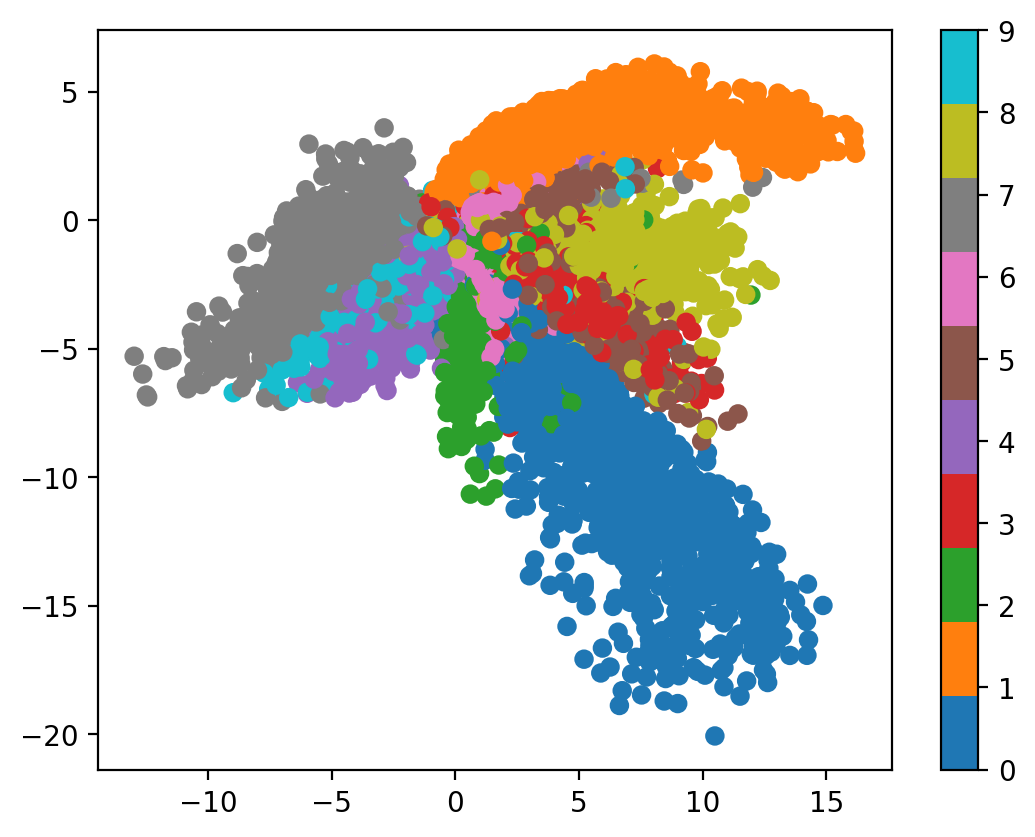

In [21]:
plot_latent(autoencoder, data)

In [24]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

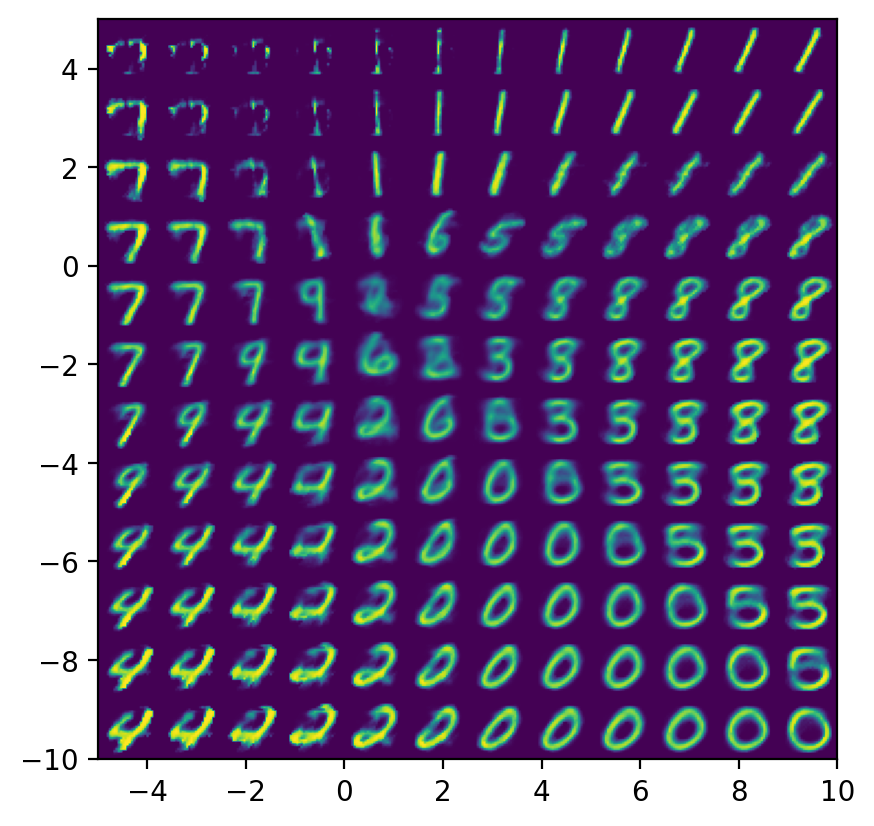

In [25]:
plot_reconstructed(autoencoder)